# Ion stress response

In [1]:
from __future__ import print_function, division, absolute_import

import sys

import qminospy
from qminospy.me2 import ME_NLP

# python imports
from copy import copy
import re
from os.path import join
from collections import defaultdict
import pickle

# third party imports
import pandas
import cobra
from tqdm import tqdm
import numpy as np
import scipy
import matplotlib.pyplot as plt

# COBRAme
import cobrame
from cobrame.util import building, mu, me_model_interface
from cobrame.io.json import save_json_me_model, save_reduced_json_me_model

# ECOLIme
import ecolime
from ecolime import (transcription, translation, flat_files, generics, formulas, compartments)
from ecolime.util.helper_functions import *
%load_ext autoreload
%autoreload 2
print(cobra.__file__)
print(cobrame.__file__)
print(ecolime.__file__)

/home/jt/Downloads/cobrapy-0.5.11/cobra/io/sbml3.py:24: UserWarning: Install lxml for faster SBML I/O
  warn("Install lxml for faster SBML I/O")
/home/jt/Downloads/cobrapy-0.5.11/cobra/io/__init__.py:12: UserWarning: cobra.io.sbml requires libsbml
  warn("cobra.io.sbml requires libsbml")


/home/jt/Downloads/cobrapy-0.5.11/cobra/__init__.py
/home/jt/UCSD/cobrame-master/cobrame/__init__.py
/home/jt/UCSD/bacillusme-master/ecolime/__init__.py


Load

In [2]:
eco_directory = join(flat_files.ecoli_files_dir, 'iJO1366.json')
ijo_directory = join(flat_files.ecoli_files_dir, 'iYO844.json')
uni_directory = join(flat_files.ecoli_files_dir, 'universal_model.json')

eco = cobra.io.load_json_model(eco_directory)
bsub = cobra.io.load_json_model(ijo_directory)
uni = cobra.io.load_json_model(uni_directory)

bsub.optimize()
base_mu = bsub.solution.f

## ME-model simulations

In [3]:
with open('../me_models/solution.pickle', 'rb') as solution:
    me = pickle.load(solution)

In [4]:
ions = ['na1_c','ca2_c','zn2_c','k_c']

Add ion uptake through osmosis

In [5]:
for ion in ions:
    rxn = cobrame.MEReaction(id='EX_{}_osm'.format(ion))
    me.add_reaction(rxn)
    rxn.reaction = ' -> '+ion
    rxn.lower_bound = 0
    rxn.upper_bound = 0

In [6]:
def single_flux_response(me,rate,ion,mu_fix=False):  
    me.reactions.get_by_id('EX_{}_osm'.format(ion)).lower_bound = rate
    me.reactions.get_by_id('EX_{}_osm'.format(ion)).upper_bound = rate
    solve_me_model(me, max_mu = 0.5, min_mu = .05, using_soplex=False,
                   precision = 1e-6,verbosity=0,mu_fix=mu_fix)
    return rate, me.solution.x_dict

In [7]:
# Calculation at several sodium uptake rates
all_rxns = [rxn.id for rxn in me.reactions]
ion_rates = -np.arange(0,100,10)

print('Ions to include: {}'.format(ions))
print('Rates to use: {}'.format(ion_rates))

ion_result_macrodict = dict()

import multiprocessing as mp
NP = min([len(ion_rates),10])

Ions to include: ['na1_c', 'ca2_c', 'zn2_c', 'k_c']
Rates to use: [  0 -10 -20 -30 -40 -50 -60 -70 -80 -90]


In [8]:
# Parallel processing
pbar = tqdm(total=len(ions)*len(ion_rates))
for ion in ions:  
    flux_dict = {}  
    pbar.set_description('Calculating {} ({} threads)'.format(ion,NP))
    def collect_result(result):
        flux_dict[result[0]] = result[1]
        pbar.update(1)
    pool = mp.Pool(NP)
    for rate in ion_rates:
        pool.apply_async(single_flux_response, args=(me,rate,ion), callback=collect_result)
    pool.close()
    pool.join()
    ion_result_macrodict[ion] = flux_dict
    flux_responses_me = pd.DataFrame.from_dict(flux_dict)
    flux_responses_me = flux_responses_me[sorted(flux_responses_me.columns)]
    flux_responses_me.to_csv('{}_flux_responses.csv'.format(ion))

Calculating k_c (10 threads): 100%|██████████| 40/40 [1:14:46<00:00, 34.55s/it]   

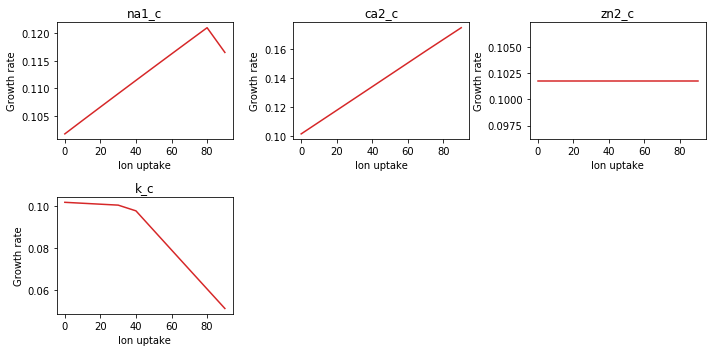

In [9]:
plt.figure(figsize=(10,5))
for idx,ion in enumerate(ions):
    plt.subplot(2,3,idx+1)
    flux_responses_me = pd.DataFrame.from_dict(ion_result_macrodict[ion])
    flux_responses_me = flux_responses_me[sorted(flux_responses_me.columns)]

    plt.plot(-flux_responses_me.loc['EX_{}_osm'.format(ion)],flux_responses_me.loc['biomass_dilution'],
                label = 'growth',color='tab:red')
    plt.xlabel('Ion uptake')
    plt.ylabel('Growth rate')
    plt.title(ion)
plt.tight_layout()

In [12]:
gene_dictionary = pd.read_csv('gene_name_dictionary.csv',index_col=1)

In [23]:
bsub.reactions.EX_k_e.genes

frozenset()

In [25]:
get_reactions_of_met(me,'k_e')

( Kt2r_FWD_BSU26640-MONOMER 0 999999.0 ) 	 h_e + k_e <=> -9.15996565006832e-5*mu BSU26640-MONOMER + h_c + k_c
( Kt2r_FWD_CPLX8J2-165 0 999999.0 ) 	 h_e + k_e <=> -4.27350427350427e-6*mu CPLX8J2-165 + h_c + k_c
( EX_k_e -999999.0 999999.0 ) 	 k_e <=> 
( Kt3r_FWD_BSU31650-MONOMER 0 999999.0 ) 	 h_e + k_c <=> -0.000250009142655074*mu BSU31650-MONOMER + h_c + k_e
( ZN2t4_FWD_BSU26650-MONOMER 0 999999.0 ) 	 h_e + k_e + zn2_c <=> -0.000101343392647356*mu BSU26650-MONOMER + h_c + k_c + zn2_e
( Kt3r_FWD_BSU31600-MONOMER 0 999999.0 ) 	 h_e + k_c <=> -4.27350427350427e-6*mu BSU31600-MONOMER + h_c + k_e
( CD2t4_FWD_BSU26650-MONOMER 0 999999.0 ) 	 cd2_c + h_e + k_e <=> -4.27350427350427e-6*mu BSU26650-MONOMER + cd2_e + h_c + k_c
( Kt1_REV_BSU31322-MONOMER 0 999999.0 ) 	 k_c <=> -3.40320963111916e-5*mu BSU31322-MONOMER + k_e
( Kt3r_FWD_BSU31620-MONOMER 0 999999.0 ) 	 h_e + k_c <=> -4.27350427350427e-6*mu BSU31620-MONOMER + h_c + k_e
( Kt3r_FWD_BSU31630-MONOMER 0 999999.0 ) 	 h_e + k_c <=> -4.273504

[<MetabolicReaction Kt2r_FWD_BSU26640-MONOMER at 0x7fc1fcbe8400>,
 <MetabolicReaction Kt2r_FWD_CPLX8J2-165 at 0x7fc1fcbe8630>,
 <MEReaction EX_k_e at 0x7fc200be9438>,
 <MetabolicReaction Kt3r_FWD_BSU31650-MONOMER at 0x7fc1fcbe8a58>,
 <MetabolicReaction ZN2t4_FWD_BSU26650-MONOMER at 0x7fc1fc8bd4a8>,
 <MetabolicReaction Kt3r_FWD_BSU31600-MONOMER at 0x7fc1fcbe8cc0>,
 <MetabolicReaction CD2t4_FWD_BSU26650-MONOMER at 0x7fc1fcf1fcf8>,
 <MetabolicReaction Kt1_REV_BSU31322-MONOMER at 0x7fc1fcbe8ef0>,
 <MetabolicReaction Kt3r_FWD_BSU31620-MONOMER at 0x7fc1fcbe8748>,
 <MetabolicReaction Kt3r_FWD_BSU31630-MONOMER at 0x7fc1fcbe8940>,
 <MetabolicReaction Kt1_FWD_BSU31322-MONOMER at 0x7fc1fcbf6160>,
 <MetabolicReaction Kt3r_FWD_BSU31610-MONOMER at 0x7fc1fcbe8ba8>,
 <MetabolicReaction Kt3r_FWD_BSU31660-MONOMER at 0x7fc1fcbe8dd8>]

/home/jt/UCSD/ME_modelling/ME_env/lib/python3.6/site-packages/ipykernel_launcher.py:9 FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike


TypeError: must be str, not float

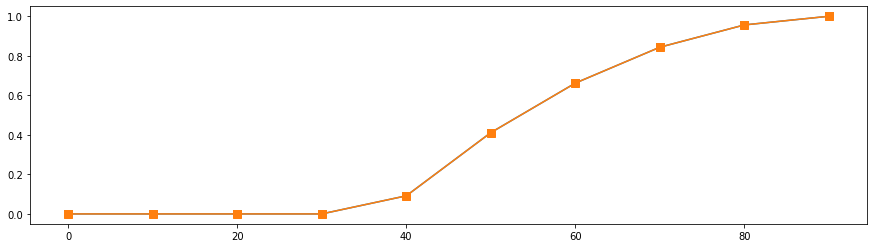

In [26]:
# Visualize protein expression profiles
plt.figure(figsize=(15,4))
import itertools
marker = itertools.cycle(('v', 's', '^', 'o', '*')) 

flux_responses_me[abs(flux_responses_me)<1e-20] = 0

plt.figure()
plt.subplots_adjust(wspace=0.3)
plt.subplot(1,2,1)
genes = ['ktrB','ktrA']
for gene_name,locus_id in gene_dictionary.loc[genes]['locus_id'].items():
    expression = flux_responses_me.loc['translation_'+locus_id]
    expression /= np.max(expression)
    plt.plot(-flux_responses_me.loc['EX_k_c_osm'],expression,
            label=gene_name,marker = next(marker),markersize=8)
plt.legend()
plt.xlabel('Sodium uptake')
plt.ylabel('Protein expression')
plt.title('Protein: K+ transporter KtrAB')

plt.subplot(1,2,1)
genes = ['ktrB','ktrA']
for gene_name,locus_id in gene_dictionary.loc[genes]['locus_id'].items():
    expression = flux_responses_me.loc['translation_'+locus_id]
    expression /= np.max(expression)
    plt.plot(-flux_responses_me.loc['EX_k_c_osm'],expression,
            label=gene_name,marker = next(marker),markersize=8)
plt.legend()
plt.xlabel('Sodium uptake')
plt.ylabel('Protein expression')
plt.title(genes)